In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plot_movies
import seaborn as sns
%matplotlib inline
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [2]:
movie_df = plot_movies.format_data()
index_by_gross = movie_df.set_index(["gross"])
top50 = index_by_gross.sort_index(ascending = False).head(50)
top50.index.name = "gross"
top100 = index_by_gross.sort_index(ascending = False).head(100)
top100.index.name = "gross"
top500 = index_by_gross.sort_index(ascending = False).head(500)
top500.index.name = "gross"
top500 = top500.reset_index()
#studio_gross_df = pd.pivot_table(movie_df, values='gross', index=['Studio'], aggfunc=np.sum)
#studio_gross_df = studio_gross_df[studio_gross_df > 1000]

Studio
DreamWorks Animation               3747.045253
Pixar Animation Studios            2885.427315
Twentieth Century Fox Animation    1032.948077
Universal Pictures                 1379.682960
Walt Disney Pictures               3944.117172

In [3]:
pixar = top50[top50.Studio == "Pixar Animation Studios"].reset_index()
disney = top100[top100.Studio == "Walt Disney Pictures"].head(11).reset_index()
dreamworks = top100[(top100.Studio == "DreamWorks") | (top100.Studio == "DreamWorks Animation")].head(20).reset_index()

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.]),
 <a list of 10 Text yticklabel objects>)

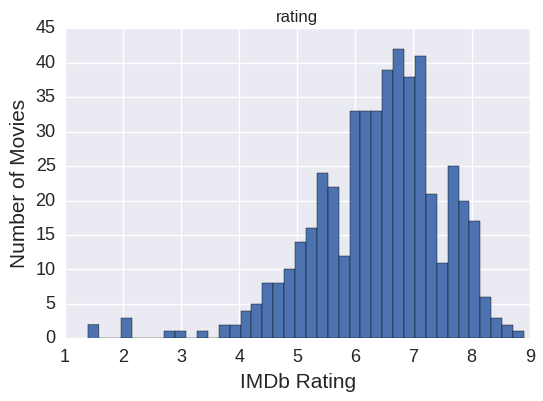

In [4]:
top500.hist("rating", bins=40)
plt.xlabel('IMDb Rating',fontsize=15)
plt.ylabel('Number of Movies', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

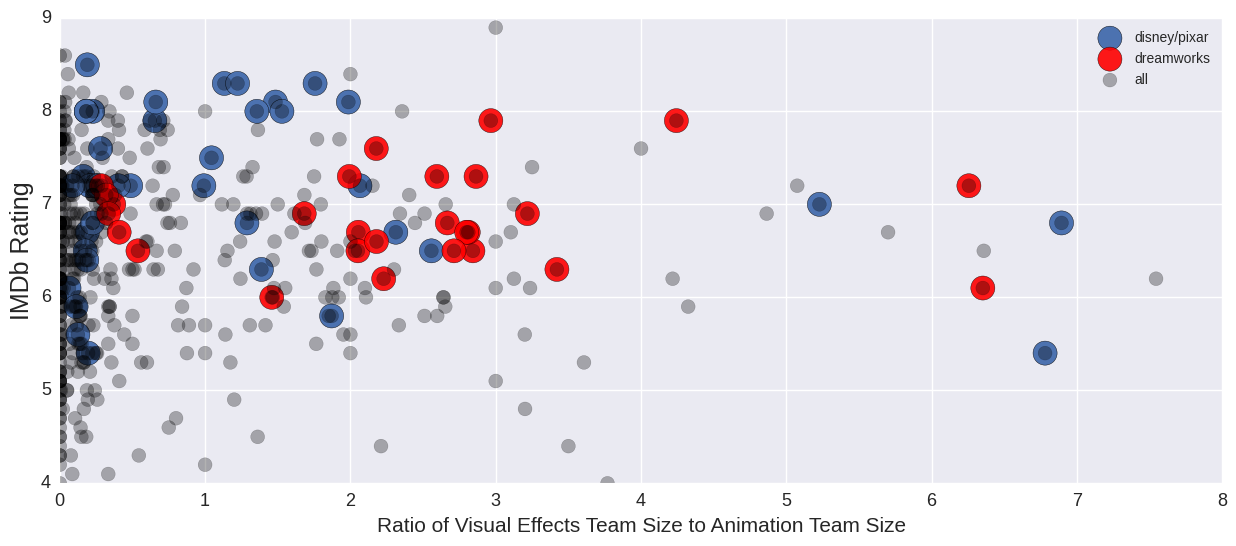

In [6]:
allpixar = top500[top500.Studio == "Pixar Animation Studios"]
alldisney = top500[top500.Studio == "Walt Disney Pictures"]
alldreamworks = top500[(top500.Studio == "DreamWorks") | (top500.Studio == "DreamWorks Animation")]
ax = allpixar.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                               alpha = 1)
alldisney.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
                          label='disney/pixar', alpha = 1, ax=ax)
alldreamworks.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                              color='r', label='dreamworks', alpha = 0.9, ax=ax)
top500.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=100, color='k', 
                          label='all', alpha = 0.3, ax=ax)
plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([0,8])
plt.ylim([4,9])
plt.ylabel('IMDb Rating', fontsize=18)

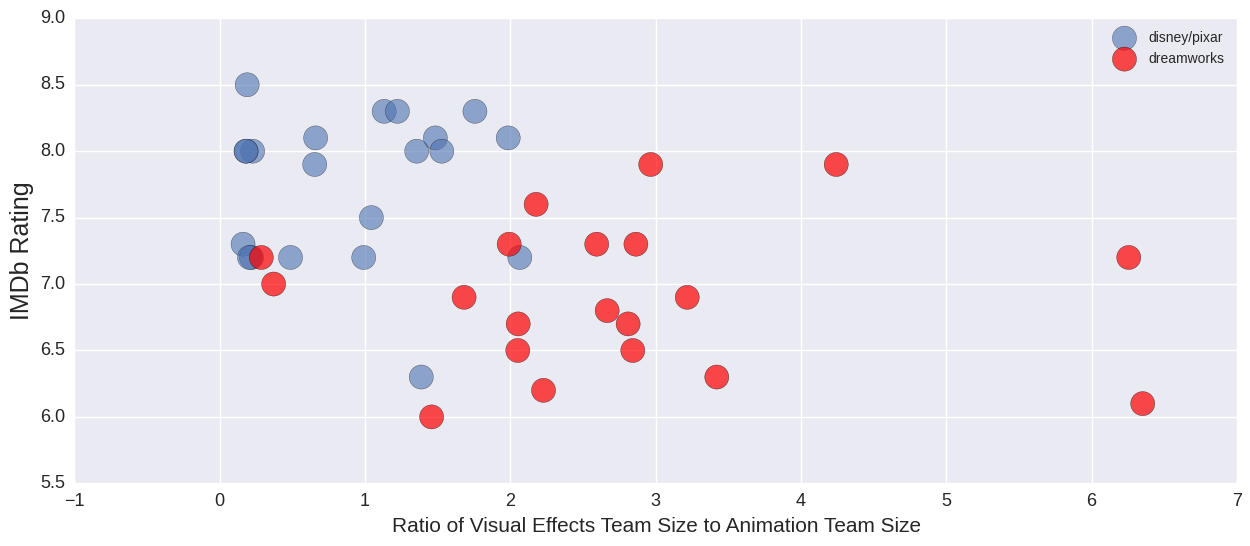

In [7]:
ax = pixar.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                               alpha = 0.6)
disney.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
                          label='disney/pixar', alpha = 0.6, ax=ax)
dreamworks.plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                              color='r', label='dreamworks', alpha = 0.7, ax=ax)
plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel('IMDb Rating', fontsize=18)

In [8]:
#ax = pixar.plot(x="writersproducers_score", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
#                               alpha = 0.6)
#disney.plot(x="writersproducers_score", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
#                          label='disney/pixar', alpha = 0.6, ax=ax)
#dreamworks.plot(x="writersproducers_score", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
#                              color='r', label='dreamworks', alpha = 0.7, ax=ax)
#plt.xlabel('LOG(Writers Score Plus Producers Score)',fontsize=15)
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.xlim([2.5, 6])
#plt.ylabel('IMDb Rating', fontsize=18)

In [17]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.cross_validation import train_test_split

numbers_df_scaled = numbers_df
numbers_df_scaled[["ratio"]] = numbers_df.ratio.divide(numbers_df.ratio.max())
numbers_df_scaled[["num_crew"]] = numbers_df.num_crew.divide(numbers_df.num_crew.max())
numbers_df_scaled[["writersproducers_score"]] = numbers_df.writersproducers_score.divide(
    numbers_df.writersproducers_score.max())
#numbers_df_scaled[["directors_score"]] = numbers_df.directors_score.divide(numbers_df.directors_score.max())
#numbers_df_scaled[["producers_score"]] = numbers_df.producers_score.divide(numbers_df.producers_score.max())
X = numbers_df_scaled[['ratio','num_crew','writersproducers_score']].as_matrix()

Y = numbers_df_scaled.binary_rating.tolist()
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2)
clf = LogisticRegressionCV(cv = 10, scoring='f1')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)
#print clf.coef_[0][1]*numbers_df.num_crew.max()
#print clf.coef_
#precision_recall_fscore_support(y_test, y_test_pred)

array([[11,  0],
       [ 1,  2]])

In [18]:
top500_scaled = top500
top500_scaled[["ratio"]] = top500.ratio.divide(top500.ratio.max())
top500_scaled[["num_crew"]] = top500.num_crew.divide(top500.num_crew.max())
top500_scaled[["writersproducers_score"]] = top500.writersproducers_score.divide(top500.writersproducers_score.max())
top500_scaled[["budget"]] = top500.budget.divide(top500.budget.max())
X = top500_scaled[['writersproducers_score', 'budget']].as_matrix()
Y = top500_scaled.binary_rating.tolist()
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2)
clf = LogisticRegressionCV(cv = 10, scoring='f1')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)
print clf.coef_[0][0]*numbers_df.writersproducers_score.max()
#print clf.coef_
#precision_recall_fscore_support(y_test, y_test_pred)

0.000260335046019


In [11]:
top500_df = top500[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'num_visual_fx', 'num_writers',
                        'num_animators', 'num_music', 'num_artists', 'num_producers', 'num_directors',
                   'writers_score']]
## compare 2 features at a time by calculating the Pearson coefficients for all potential correlations:
#heatmap_df = top500_df.corr()
#f, ax = plt.subplots(figsize=(7,7))
#sns.heatmap(heatmap_df, vmax=1, square=True)

In [12]:
df1 = pixar[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'num_visual_fx', 'num_writers', 
             'budget','writers_score','binary_rating', 'directors_score', 'producers_score', 'num_animators',
             'num_music', 'num_artists', 'num_producers', 'num_directors']]
df2 = disney[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'num_visual_fx', 'num_writers', 
             'budget','writers_score','binary_rating', 'directors_score', 'producers_score', 'num_animators',
             'num_music', 'num_artists', 'num_producers', 'num_directors']]
df3 = dreamworks[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'num_visual_fx', 'num_writers', 
             'budget','writers_score','binary_rating', 'directors_score', 'producers_score', 'num_animators',
             'num_music', 'num_artists', 'num_producers', 'num_directors']]
numbers_df = pd.concat([df1, df2, df3], ignore_index=True)
## compare 2 features at a time by calculating the Pearson coefficients for all potential correlations:
#heatmap_df = numbers_df.corr()
#f, ax = plt.subplots(figsize=(7,7))
#sns.heatmap(heatmap_df, vmax=1, square=True)

In [13]:
df4 = allpixar[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'writers_score','binary_rating',
            'directors_score', 'producers_score', 'writersproducers_score', 'budget']]
df5 = alldisney[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'writers_score','binary_rating',
            'directors_score', 'producers_score', 'writersproducers_score', 'budget']]
df6 = alldreamworks[['rating', 'num_ratings', 'gross', 'ratio', 'num_crew', 'writers_score','binary_rating',
            'directors_score', 'producers_score', 'writersproducers_score', 'budget']]
numbers_df = pd.concat([df4, df5, df6], ignore_index=True)
## compare 2 features at a time by calculating the Pearson coefficients for all potential correlations:
#heatmap_df = numbers_df.corr()

## Create a heatmap from the coeffs calculated above:
#f, ax = plt.subplots(figsize=(7,7))
#sns.heatmap(heatmap_df, vmax=1, square=True)

In [14]:
pixardisney_dict = {}

pixar_titles = pixar.title.tolist()
pixar_writers = pixar.writers.tolist()
pixar_dict = {}
for idx, title in enumerate(pixar_titles):
    pixar_dict[title.strip()] = [writer.strip() for writer in pixar_writers[idx]]
    pixardisney_dict[title.strip()] = [writer.strip() for writer in pixar_writers[idx]]
    
disney_titles = disney.title.tolist()
disney_writers = disney.writers.tolist()
disney_dict = {}
for idx, title in enumerate(disney_titles):
    disney_dict[title.strip()] = [writer.strip() for writer in disney_writers[idx]]
    pixardisney_dict[title.strip()] = [writer.strip() for writer in disney_writers[idx]]


dreamworks_titles = dreamworks.title.tolist()
dreamworks_writers = dreamworks.writers.tolist()
dreamworks_dict = {}
for idx, title in enumerate(dreamworks_titles):
    dreamworks_dict[title.strip()] = [writer.strip() for writer in dreamworks_writers[idx]]

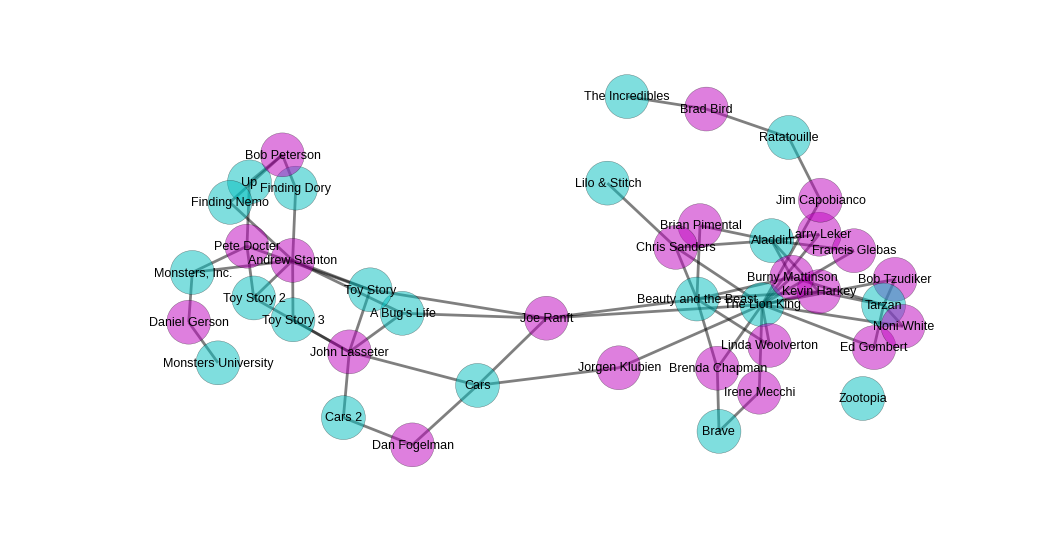

In [16]:
PixDis=plot_movies.make_network_graph(pixardisney_dict, degree_to_trim=1)
pos=nx.spring_layout(PixDis, k=0.1)
plt.figure(3,figsize=(10,5)) 
nx.draw(PixDis, pos,node_color=plot_movies.get_colors(PixDis), node_size=1000, width=2, edge_cmap=plt.cm.Blues, 
        alpha=0.5, font_size=9, with_labels=True)